 **Midterm: Neural Network-Based Language
Model for Next Token Prediction**


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split


**Load Icelandic and English text files**

In [2]:
# Load Icelandic and English text files
with open('/content/Icelandic_sampled.txt', 'r', encoding='utf-8') as f:
    icelandic_text = f.read()

with open('/content/alpaca_sampled.txt', 'r', encoding='utf-8') as f:
    english_text = f.read()

print("Datasets loaded successfully.")

# Preprocessing function to clean text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-ZÍÚÁÉÓÖÞÆÉíúáéóöþæ ]', '', text)  # Retain Icelandic letters
    return text

# Apply preprocessing to both datasets
english_text = preprocess_text(english_text)
icelandic_text = preprocess_text(icelandic_text)

print(f"Sample of English Text: {english_text[:100]}")
print(f"Sample of Icelandic Text: {icelandic_text[:100]}")



Datasets loaded successfully.
Sample of English Text: instruction explain newtons third law of motion input  output newtons third law of motion states tha
Sample of Icelandic Text: instruction kindly translate the given sentence into icelandic input write a comment praising the gi


** Tokenization function**

In [3]:
# Tokenization function
def tokenize(text):
    return text.split()

english_tokens = tokenize(english_text)
icelandic_tokens = tokenize(icelandic_text)

print(f"English tokens: {len(english_tokens)}")
print(f"Icelandic tokens: {len(icelandic_tokens)}")

# Build vocabulary
def build_vocab(tokens):
    vocab = Counter(tokens)
    vocab = {word: i for i, (word, _) in enumerate(vocab.items())}
    return vocab

# Create vocabularies for both languages
english_vocab = build_vocab(english_tokens)
icelandic_vocab = build_vocab(icelandic_tokens)

print(f"English Vocabulary Size: {len(english_vocab)}")
print(f"Icelandic Vocabulary Size: {len(icelandic_vocab)}")

# Convert tokens to indices
english_data = [english_vocab[word] for word in english_tokens]
icelandic_data = [icelandic_vocab[word] for word in icelandic_tokens]

# Combine datasets
combined_data = english_data + icelandic_data
print(f"Combined dataset size: {len(combined_data)}")


English tokens: 32477
Icelandic tokens: 36422
English Vocabulary Size: 6221
Icelandic Vocabulary Size: 9601
Combined dataset size: 68899


**Dataset class for sequence prediction**

In [4]:
# Dataset class for sequence prediction
class TextDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx:idx + self.sequence_length]),
                torch.tensor(self.data[idx + self.sequence_length]))

# Sequence length for training
sequence_length = 5

# Create the combined dataset
combined_dataset = TextDataset(combined_data, sequence_length)
print(f"Dataset length: {len(combined_dataset)}")

# Split into training and validation sets
train_data, val_data = train_test_split(combined_dataset, test_size=0.1)
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

# Create DataLoaders for training and validation
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Dataset length: 68894
Training samples: 62004, Validation samples: 6890
Batch size: 64
Training batches: 969, Validation batches: 108


**Loss function and optimizer**

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Function to train the model and validate
def train_model(model, train_loader, val_loader, optimizer, num_epochs, checkpoint_path):
    model.train()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        # Save checkpoint for every epoch
        torch.save(model.state_dict(), f'{checkpoint_path}_epoch{epoch+1}.pth')

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

    import pandas as pd
import numpy as np

# Train the model
num_epochs = 10
train_losses, val_losses = train_model(combined_model, train_loader, val_loader, optimizer, num_epochs, 'combined_model_checkpoint')

# Save training and validation losses to a CSV file
losses_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train_Loss': train_losses,
    'Val_Loss': val_losses
})
losses_df.to_csv('training_validation_losses.csv', index=False)


Epoch 1/10, Train Loss: 7.6275, Val Loss: 7.1583
Epoch 2/10, Train Loss: 6.6923, Val Loss: 6.9158
Epoch 3/10, Train Loss: 5.9922, Val Loss: 6.8872
Epoch 4/10, Train Loss: 5.1496, Val Loss: 7.0510
Epoch 5/10, Train Loss: 4.2123, Val Loss: 7.2246
Epoch 6/10, Train Loss: 3.2722, Val Loss: 7.5333
Epoch 7/10, Train Loss: 2.4096, Val Loss: 7.8671
Epoch 8/10, Train Loss: 1.6956, Val Loss: 8.1713
Epoch 9/10, Train Loss: 1.1467, Val Loss: 8.4934
Epoch 10/10, Train Loss: 0.7460, Val Loss: 8.7863


**final model**

In [15]:
# Save the final model
torch.save(combined_model.state_dict(), 'combined_model.pth')

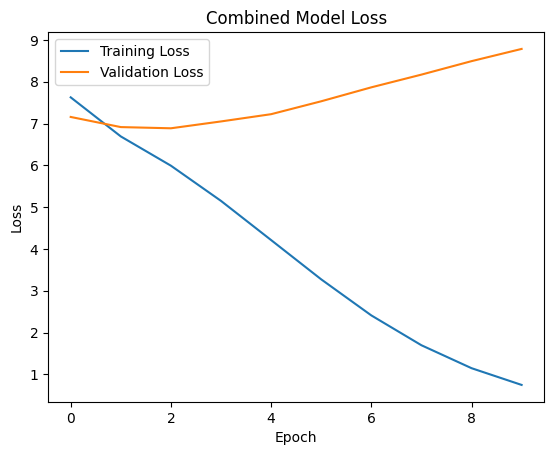

In [14]:

# Plot losses
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('model_loss.png')
    plt.show()

# Plot combined model losses
plot_losses(train_losses, val_losses, 'Combined Model Loss')



**perplexity based on the validation set**

In [9]:
# Calculate perplexity based on the validation set
def calculate_perplexity(model, val_loader):
    model.eval()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_words += targets.size(0)

    avg_loss = total_loss / len(val_loader)
    perplexity = np.exp(avg_loss)

    return perplexity

# Perplexity calculation for the combined model
combined_perplexity = calculate_perplexity(combined_model, val_loader)
print(f'Combined Model Perplexity: {combined_perplexity:.2f}')

Combined Model Perplexity: 6543.78


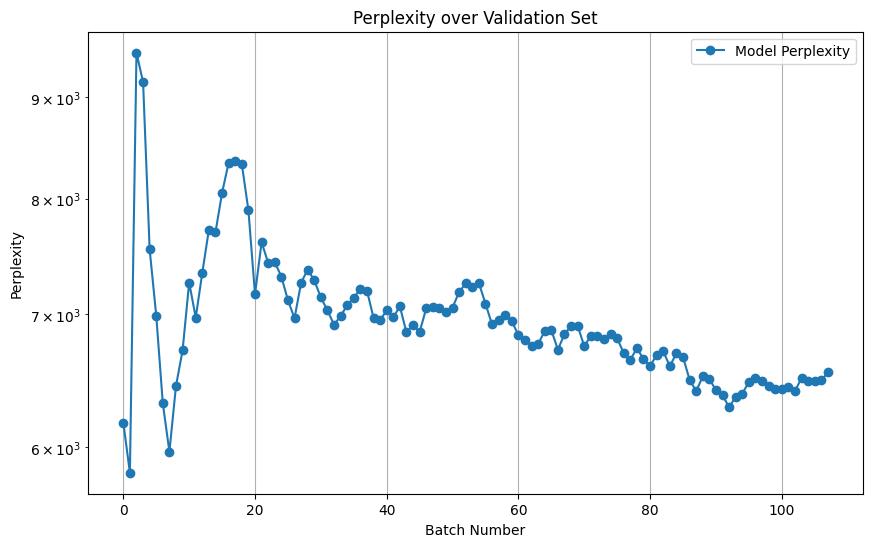

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Calculate perplexity based on the validation set
def calculate_perplexity(model, val_loader):
    model.eval()
    perplexity_values = []  # Store perplexity for each batch
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            avg_loss = total_loss / (len(perplexity_values) + 1)  # Average loss after each batch
            perplexity = np.exp(avg_loss)
            perplexity_values.append(perplexity)  # Append current perplexity

    return perplexity_values

# Perplexity calculation for the combined model
combined_perplexity = calculate_perplexity(combined_model, val_loader)

# Plotting perplexity values
plt.figure(figsize=(10, 6))
plt.plot(combined_perplexity, label='Model Perplexity', marker='o')
plt.title('Perplexity over Validation Set')
plt.xlabel('Batch Number')
plt.ylabel('Perplexity')
plt.yscale('log')  # Log scale can help visualize perplexity better if the values vary widely
plt.legend()
plt.grid()
plt.show()


**Generate text**

In [22]:
import torch.nn.functional as F

# Ensure '<UNK>' token is in the vocabularies
if '<UNK>' not in english_vocab:
    english_vocab['<UNK>'] = len(english_vocab)
if '<UNK>' not in icelandic_vocab:
    icelandic_vocab['<UNK>'] = len(icelandic_vocab)

# Reverse vocab dictionaries
english_reverse_vocab = {idx: word for word, idx in english_vocab.items()}
icelandic_reverse_vocab = {idx: word for word, idx in icelandic_vocab.items()}

# Function to generate text
def generate_text(model, vocab, reverse_vocab, seed_text, max_length=50):
    model.eval()

    # Tokenize and convert seed text to indices
    seed_tokens = [vocab.get(word, vocab['<UNK>']) for word in seed_text.split()]
    input_seq = torch.tensor(seed_tokens).unsqueeze(0)  # Add batch dimension

    generated_text = seed_text.split()

    with torch.no_grad():
        for _ in range(max_length):
            output = model(input_seq)  # Forward pass

            # Check the shape of the output
            if len(output.shape) == 2:
                # Handle (batch_size, vocab_size)
                predictions = F.softmax(output, dim=-1)
            else:
                # Handle (batch_size, sequence_length, vocab_size)
                predictions = F.softmax(output[:, -1, :], dim=-1)

            next_token_idx = torch.argmax(predictions, dim=-1).item()

            # Append the predicted token
            next_token_word = reverse_vocab.get(next_token_idx, '<UNK>')
            generated_text.append(next_token_word)

            # Update input sequence with the predicted token
            input_seq = torch.cat([input_seq, torch.tensor([[next_token_idx]])], dim=1)

    return ' '.join(generated_text)

# Generate text in English
print("Generating text in English...")
seed_text = "Today is a good ohh yes"
generated_english = generate_text(combined_model, english_vocab, english_reverse_vocab, seed_text)
print("Generated English Text:", generated_english)

# Generate text in Icelandic
print("Generating text in Icelandic...")
seed_text_icelandic = "þetta mun auka"
generated_icelandic = generate_text(combined_model, icelandic_vocab, icelandic_reverse_vocab, seed_text_icelandic)
print("Generated Icelandic Text:", generated_icelandic)


Generating text in English...
Generated English Text: Today is a good ohh yes in three research input output one is an object input output there are several types of these disasters can vary these can can can find the instance and accuracy the behavior of the given polynomial input x x x x can can add as the sentence but the speaker she
Generating text in Icelandic...
Generated Icelandic Text: þetta mun auka áberandi í utan eins og vieigandi alaandi og hjálpa til a gera gera get um a afslætti sínu sé einföld og sigrast og sanngjarnan til vinnu og gera er almennt á núverandi me frammistöu og getu getu okkar eins og okkar okkar til þátttöku og málverk til a draga úr


END END